https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/


In [1]:
import imageio
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import time
from IPython import display

In [2]:
tf.keras.backend.clear_session()

In [3]:
(train_img, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

In [4]:
train_img = train_img[:,:,:,None].astype('float32')   # adding channel
train_img = (train_img - 127.5 )/127.5    # Normalize values to [-1,1]

In [5]:
# convert the labels to one hot encoding
train_labels = keras.utils.to_categorical(train_labels,10)

In [6]:
train_labels[5]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [7]:
Buffer_size = 60000   # used to shuffle the data
Batch_size = 256

In [8]:
# batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices((train_img,train_labels)).shuffle(Buffer_size).batch(Batch_size)

In [104]:
print(train_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [181]:
for img_batch, label_batch in train_dataset:
    noise = tf.random.normal([Batch_size,100])
    # label = np.argmax(label_batch,axis=1)
    # label = label[:,None,None,None]
    # print(label.shape)
    # embedding = np.zeros(img_batch.shape)
    # print(embedding.shape)
    # embedding =  label + embedding
    # embedding /= 10
    # print(embedding.shape)
    # break
    GG_in = np.concatenate((noise,label_batch), axis=1)
    print(GG_in.shape)
    break

(256,)
(256, 110)


In [122]:
# embedding[0,1,1]

In [9]:
# input channels for generator and discriminator
latent_dim = 100
n_classes=10
n_channels=1
G_in_ch = latent_dim+n_classes
D_in_ch = n_channels+1

## Create Model

### 1. Generator

In [102]:
def generator():
    model = tf.keras.Sequential()  # input is Gaussian noise of size 100 
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(G_in_ch,))) # observed that GAN converges fast when there is no bias
    model.add(layers.BatchNormalization())  # active during training only
    model.add(layers.LeakyReLU())  # good with gradients 

    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256)  # here None refers to batch size

    model.add(layers.Conv2DTranspose(128,(5,5), strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64,(5,5), strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16,(5,5), strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape == (None, 14, 14, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1,(5,5), strides=(2,2),padding='same',use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model
    
    
    

In [103]:
# G = generator()

# noise = tf.random.normal([100])

# label = 5
# ohe = np.zeros(n_classes)
# ohe[label] = 1

# G_in = np.concatenate((noise,ohe))
# G_in = G_in[None,:]

# img = G(G_in, training=False)
# print(img.shape)
# plt.imshow(img[0,:,:,0],cmap='grey')

### 2. Discriminator
Here just the input channels for Disciminator are changed

In [104]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,2]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128,(5,5),strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(16))
    model.add(layers.Dense(1))  # logits (output without sigmoid or before sigmoid)
    # model.add(layers.Dense(1,activation='sigmoid'))

    return model


In [105]:
# D = discriminator()
# out = D(img)
# print(out)

In [106]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Here the discriminator should be able to classify real as real image and fake as fake image.

In [107]:
def discriminator_loss(real, fake):
    real_loss = cross_entropy(tf.ones_like(real), real)
    fake_loss = cross_entropy(tf.zeros_like(fake), fake)

    return real_loss+fake_loss

Here the generator should try to generate fake image such that the disciminator classifies it as real image, so the loss fro generator is cross_entropy(1,fake) as

In [108]:
def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)

In [109]:
G_opt = tf.keras.optimizers.Adam(1e-4)
D_opt = tf.keras.optimizers.Adam(1e-4)

In [110]:
G = generator()
D = discriminator()

Saving checkpoints

In [112]:
checkpoint_dir = './training_checkpoints2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=G_opt,
    discriminator_optimizer=D_opt,
    generator=G,
    discriminator=D
)

 ### Training

In [113]:
@tf.function

def train_step(img, label):
    
    noise = tf.random.normal([label.shape[0],latent_dim])
    G_in = tf.concat((noise, label),axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_img = G(G_in,training=True)
        
        label = tf.argmax(label, axis=1)
        label = label[:,None,None,None]
        
        embedding = np.zeros(img.shape)
        embedding =  label + embedding
        embedding = embedding / 10
        embedding = tf.cast(embedding, dtype=tf.float32)
        # print(embedding.shape)
        D_in_fake = tf.concat((fake_img, embedding),axis=-1)
        D_in_real = tf.concat((img, embedding),axis=-1)
        # print('b0')
        real_out = D(D_in_real, training=True)
        fake_out = D(D_in_fake, training=True)

        G_loss = generator_loss(fake_out)
        D_loss = discriminator_loss(real_out, fake_out)

    grad_G = gen_tape.gradient(G_loss, G.trainable_variables)
    grad_D = disc_tape.gradient(D_loss, D.trainable_variables)

    G_opt.apply_gradients(zip(grad_G, G.trainable_variables))
    D_opt.apply_gradients(zip(grad_D, D.trainable_variables))
    # print('b2')
    return G_loss, D_loss
    

In [114]:
@tf.function

def train_step2(img, label,E):
    
    noise = tf.random.normal([label.shape[0],latent_dim])
    G_in = tf.concat((noise, label),axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_img = G(G_in,training=True)
        
        
        e = E(label)
        e = tf.reshape(e,(e.shape[0],e.shape[1],28,28))
        e = tf.transpose(e,perm=[0,2,3,1])
        # print(e.shape)
        # print(fake_img.shape)
        D_in_fake = tf.concat((fake_img, e),axis=-1)
        D_in_real = tf.concat((img, e),axis=-1)
        # print('b0')
        real_out = D(D_in_real, training=True)
        fake_out = D(D_in_fake, training=True)

        G_loss = generator_loss(fake_out)
        D_loss = discriminator_loss(real_out, fake_out)

    grad_G = gen_tape.gradient(G_loss, G.trainable_variables)
    grad_D = disc_tape.gradient(D_loss, D.trainable_variables)

    G_opt.apply_gradients(zip(grad_G, G.trainable_variables))
    D_opt.apply_gradients(zip(grad_D, D.trainable_variables))
    # print('b2')
    return G_loss, D_loss
    

In [115]:
def train(dataset, epochs):
    
    for epoch in range(epochs):
        start = time.time()
        tot_G_loss = 0
        tot_D_loss = 0
        n = 0
        # print("e")
        for img_batch, label_batch in dataset:

            G_loss, D_loss = train_step(img_batch, label_batch)
            tot_G_loss += G_loss
            tot_D_loss += D_loss
            n += 1
            
        avg_G_loss = tot_G_loss/n
        avg_D_loss = tot_D_loss/n

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Generator Loss: {avg_G_loss:.4f}')
        print(f'Discriminator Loss: {avg_D_loss:.4f}')
        
        # See the progress of the model as it trains in the form of generated images
        # display.clear_output(wait=True)
        generate_and_save_images(G,epoch+1,seed)

        # Save the model every 10 epochs
        if(epoch+1)%10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

    # Generate after the final epoch
    # display.clear_output(wait=True)
    generate_and_save_images(G,epochs,seed)
        

In [116]:
def generate_and_save_images(model, epoch, test_input):

    pred = model(test_input, training=False)

    fig = plt.figure(figsize=(10,5))

    for i in range(pred.shape[0]):
        plt.subplot(2,5,i+1)
        plt.imshow(pred[i,:,:,0]*127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('epoch_{:0d}.png'.format(epoch))
    plt.show()
        

In [119]:
epochs = 50
noise_dim = 100
num_examples = 10
# E1 = keras.layers.Embedding(input_dim=10, output_dim=28*28)
seed = tf.random.normal([10, noise_dim])
labels = np.eye(10)
seed = np.concatenate((seed, labels),axis=1)

Epoch 1/50
Generator Loss: 1.0748
Discriminator Loss: 1.1667


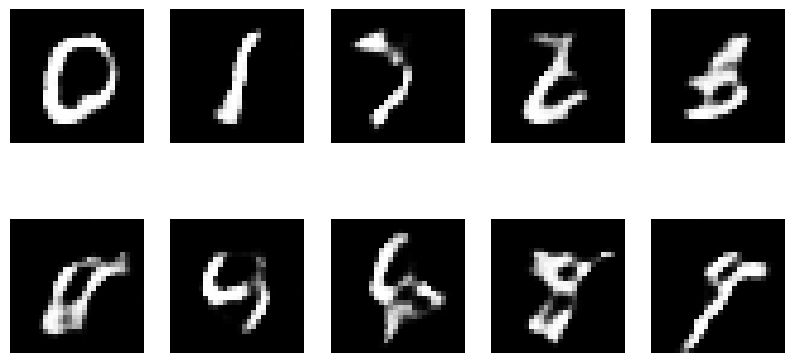

Time for epoch 1 is 19.12315034866333 sec
Epoch 2/50
Generator Loss: 1.0475
Discriminator Loss: 1.1765


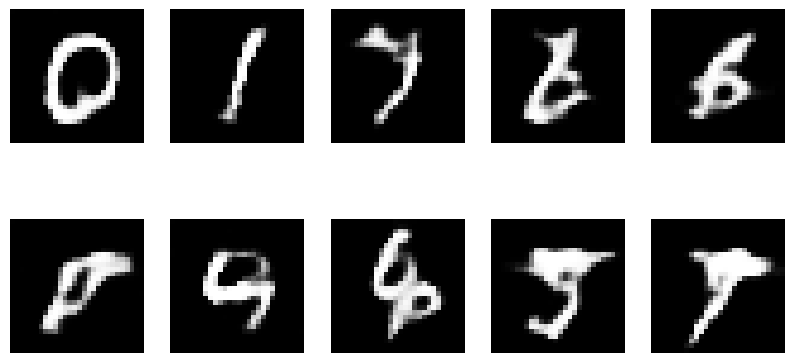

Time for epoch 2 is 18.94977593421936 sec
Epoch 3/50
Generator Loss: 1.0441
Discriminator Loss: 1.1821


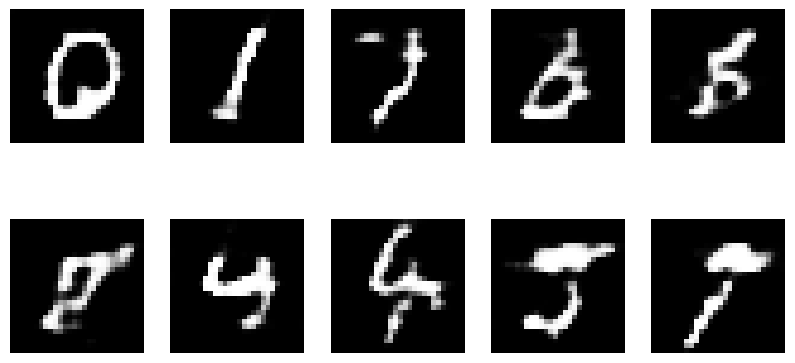

Time for epoch 3 is 19.05024766921997 sec
Epoch 4/50
Generator Loss: 1.1498
Discriminator Loss: 1.1295


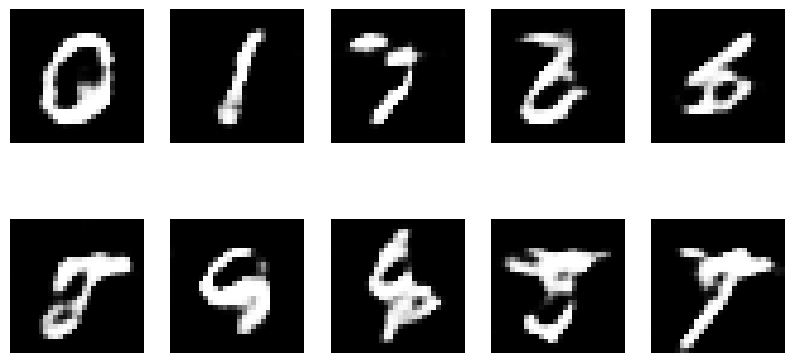

Time for epoch 4 is 19.160232543945312 sec
Epoch 5/50
Generator Loss: 1.1948
Discriminator Loss: 1.1005


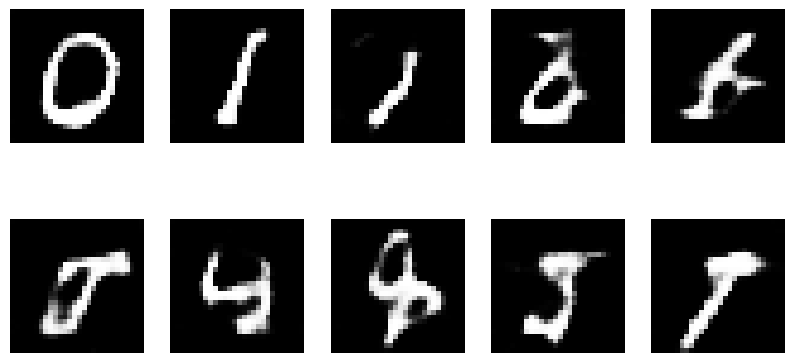

Time for epoch 5 is 19.35535168647766 sec
Epoch 6/50
Generator Loss: 1.0973
Discriminator Loss: 1.1702


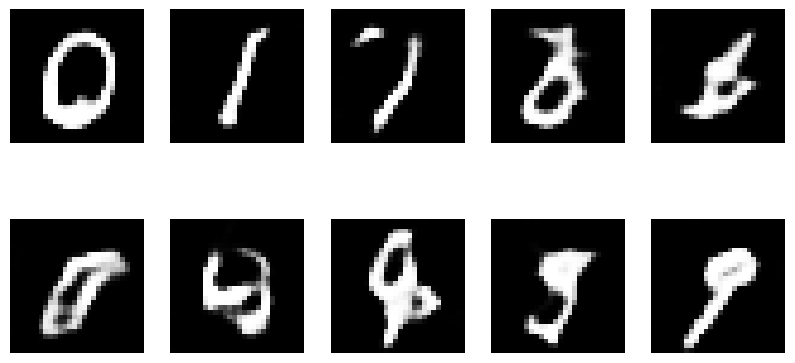

Time for epoch 6 is 19.209765911102295 sec
Epoch 7/50
Generator Loss: 1.0268
Discriminator Loss: 1.1815


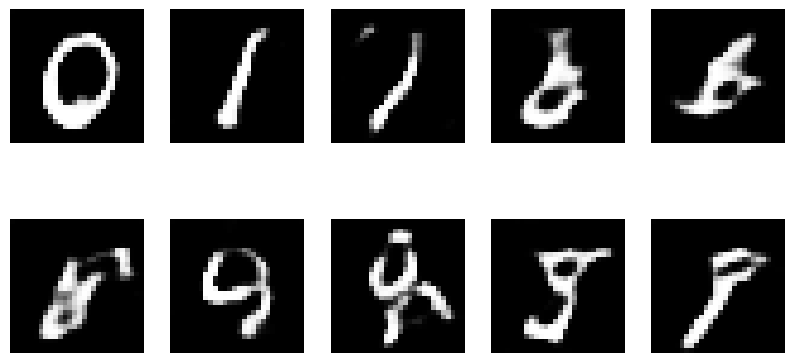

Time for epoch 7 is 19.40318751335144 sec
Epoch 8/50
Generator Loss: 1.0005
Discriminator Loss: 1.1922


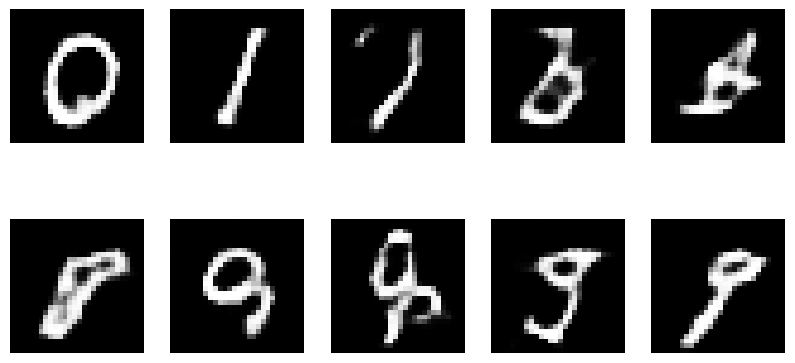

Time for epoch 8 is 19.573806285858154 sec
Epoch 9/50
Generator Loss: 1.0126
Discriminator Loss: 1.1941


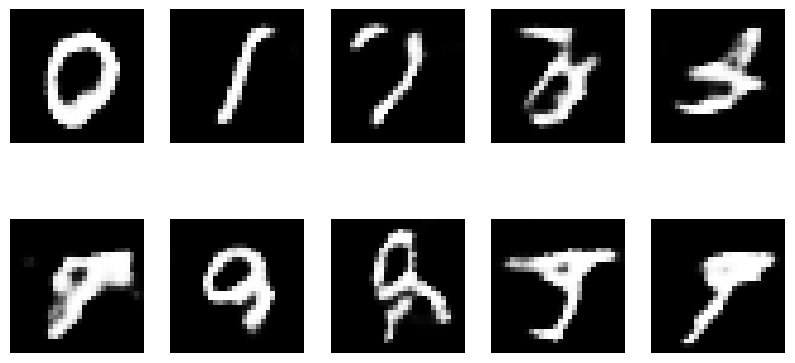

Time for epoch 9 is 19.291492700576782 sec
Epoch 10/50
Generator Loss: 1.0286
Discriminator Loss: 1.1846


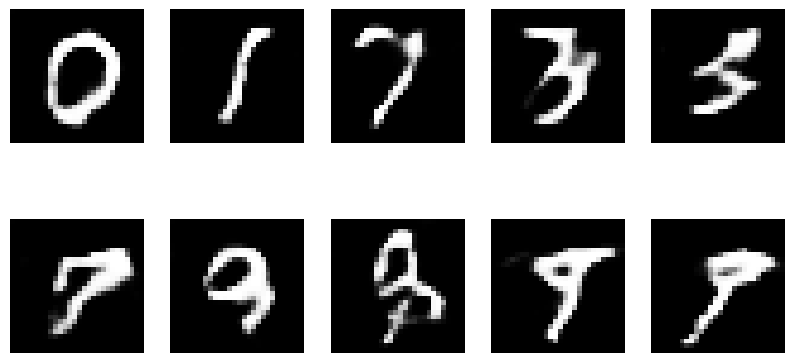

Time for epoch 10 is 19.619930267333984 sec
Epoch 11/50
Generator Loss: 1.0371
Discriminator Loss: 1.1838


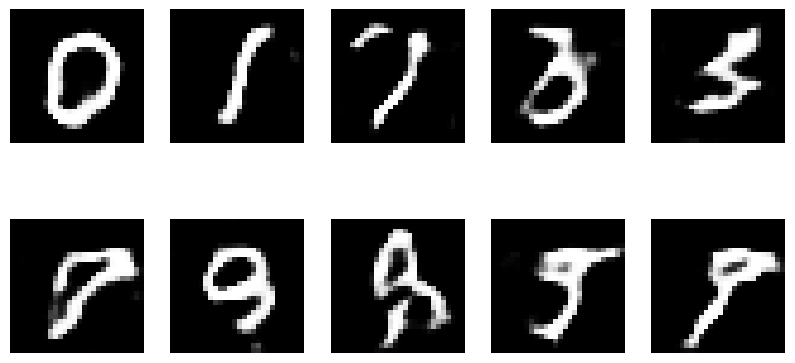

Time for epoch 11 is 19.299104928970337 sec
Epoch 12/50
Generator Loss: 1.0022
Discriminator Loss: 1.2020


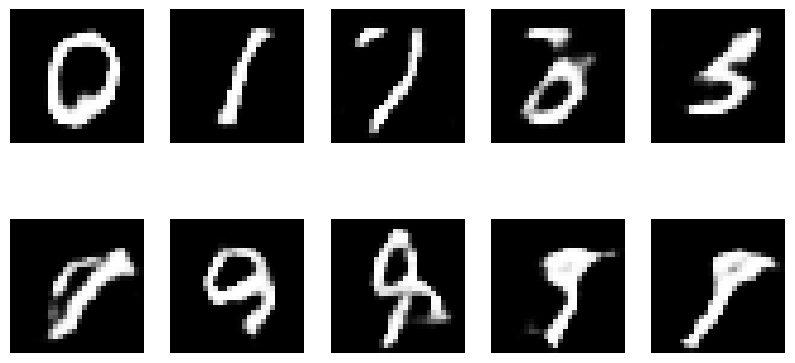

Time for epoch 12 is 19.28590440750122 sec
Epoch 13/50
Generator Loss: 0.9734
Discriminator Loss: 1.2143


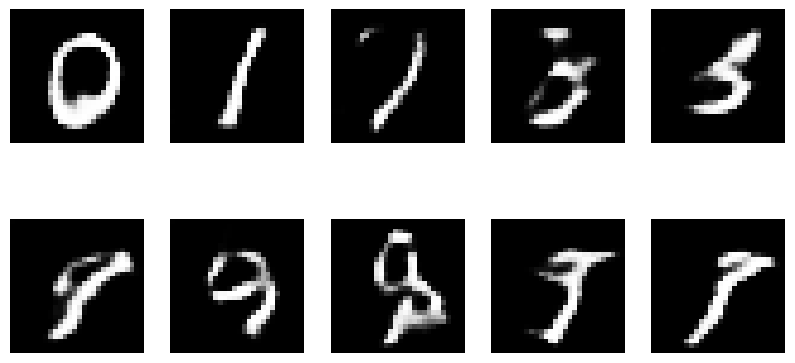

Time for epoch 13 is 19.34483003616333 sec
Epoch 14/50
Generator Loss: 0.9863
Discriminator Loss: 1.2051


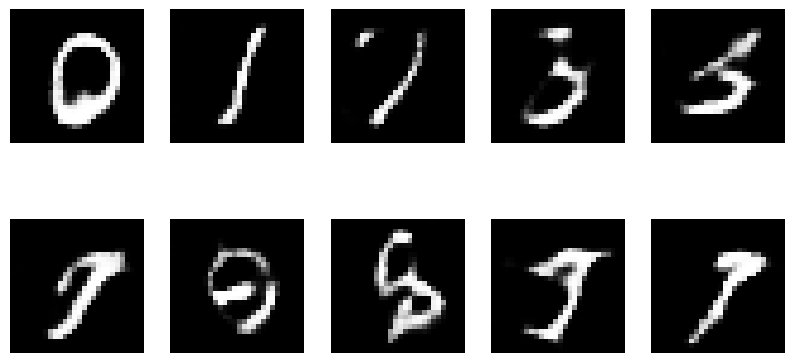

Time for epoch 14 is 19.27955174446106 sec
Epoch 15/50
Generator Loss: 0.9940
Discriminator Loss: 1.2005


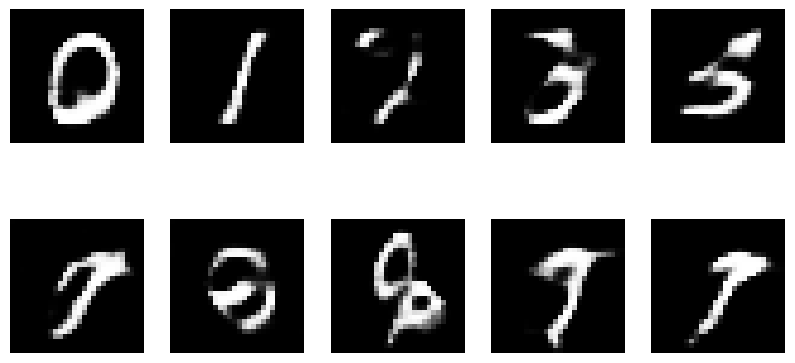

Time for epoch 15 is 19.27281665802002 sec
Epoch 16/50
Generator Loss: 0.9775
Discriminator Loss: 1.2109


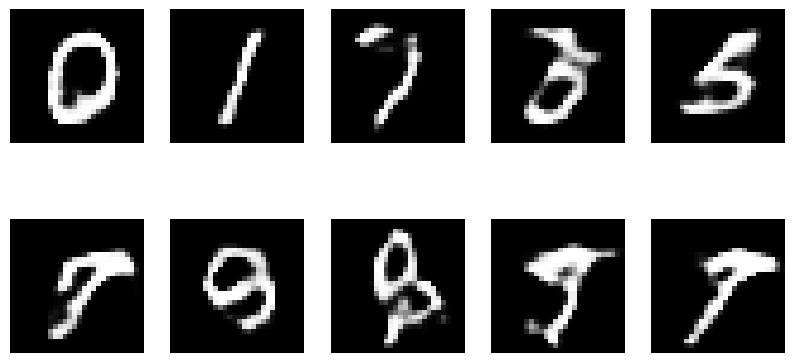

Time for epoch 16 is 19.31923246383667 sec
Epoch 17/50
Generator Loss: 0.9842
Discriminator Loss: 1.2278


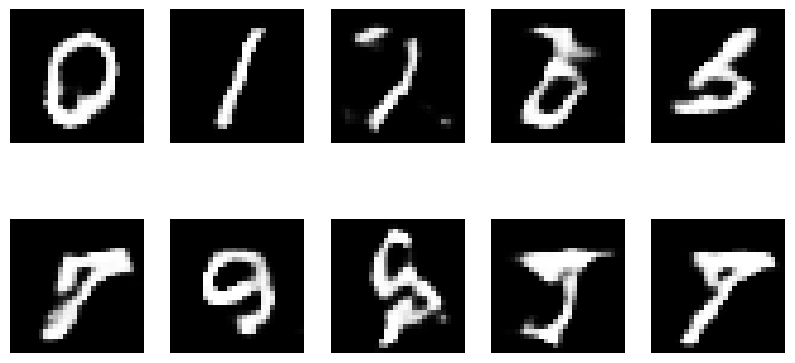

Time for epoch 17 is 19.38703489303589 sec
Epoch 18/50
Generator Loss: 0.9943
Discriminator Loss: 1.2068


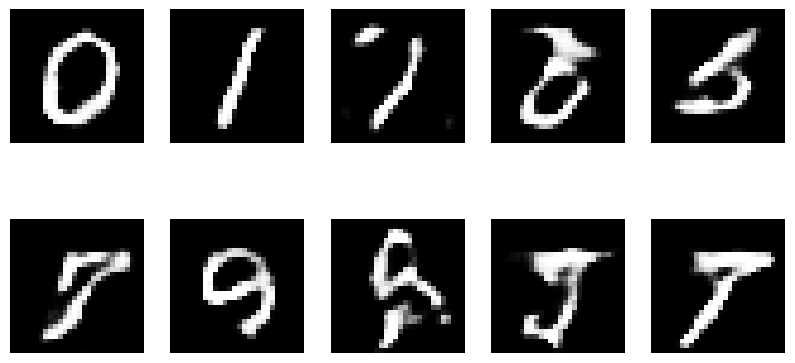

Time for epoch 18 is 19.70331120491028 sec
Epoch 19/50
Generator Loss: 0.9770
Discriminator Loss: 1.2140


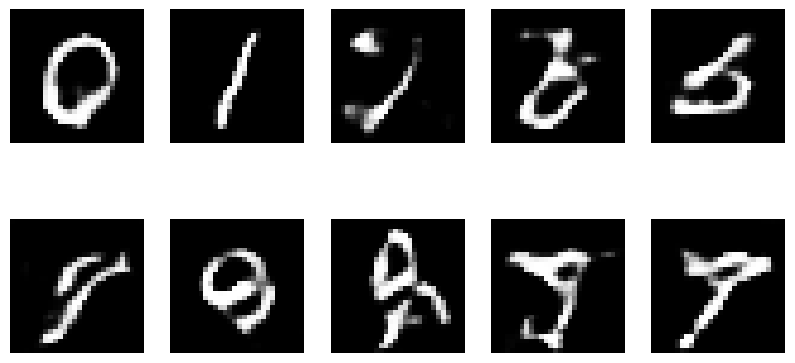

Time for epoch 19 is 19.335469484329224 sec
Epoch 20/50
Generator Loss: 0.9704
Discriminator Loss: 1.2240


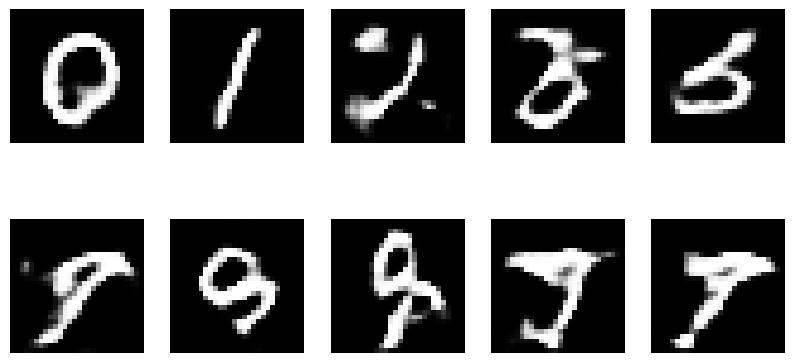

Time for epoch 20 is 19.597706079483032 sec
Epoch 21/50
Generator Loss: 0.9602
Discriminator Loss: 1.2241


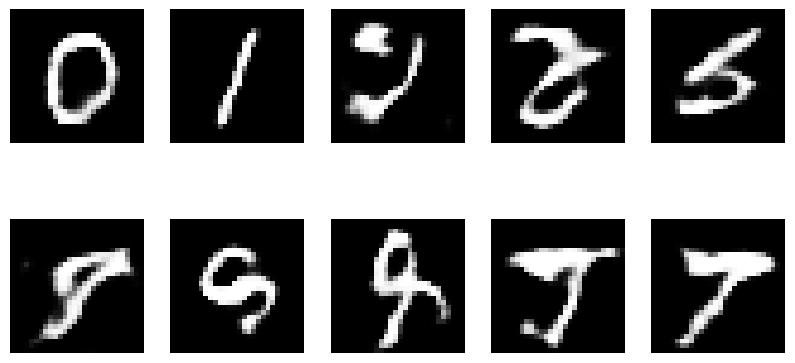

Time for epoch 21 is 19.309544563293457 sec
Epoch 22/50
Generator Loss: 0.9348
Discriminator Loss: 1.2287


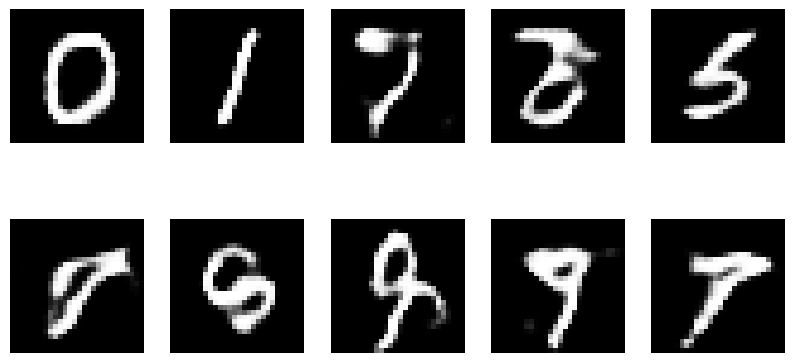

Time for epoch 22 is 19.326656341552734 sec
Epoch 23/50
Generator Loss: 0.9519
Discriminator Loss: 1.2184


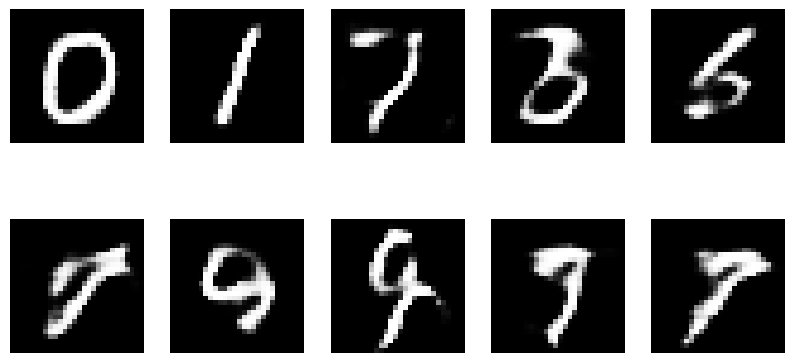

Time for epoch 23 is 19.374722480773926 sec
Epoch 24/50
Generator Loss: 0.9529
Discriminator Loss: 1.2349


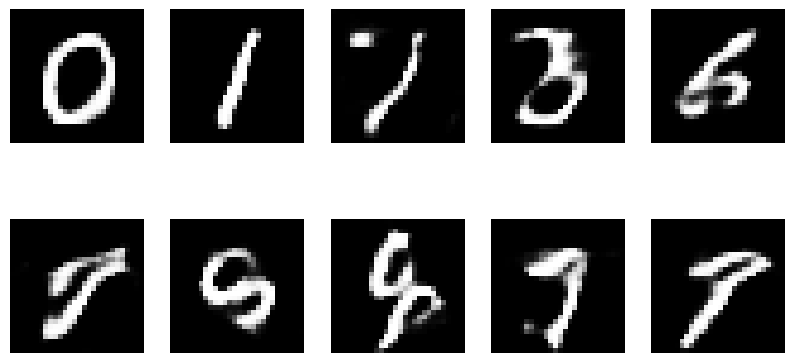

Time for epoch 24 is 19.32077646255493 sec
Epoch 25/50
Generator Loss: 0.9546
Discriminator Loss: 1.2277


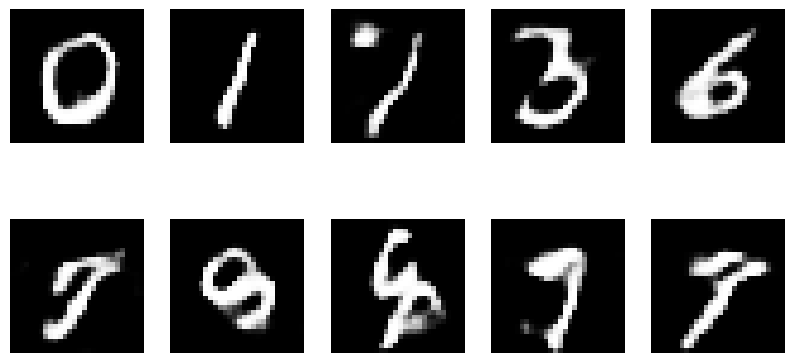

Time for epoch 25 is 19.397276639938354 sec
Epoch 26/50
Generator Loss: 0.9479
Discriminator Loss: 1.2311


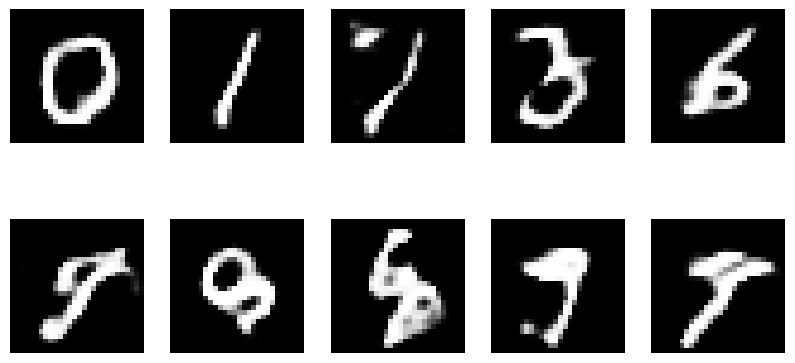

Time for epoch 26 is 19.311163902282715 sec
Epoch 27/50
Generator Loss: 0.9383
Discriminator Loss: 1.2339


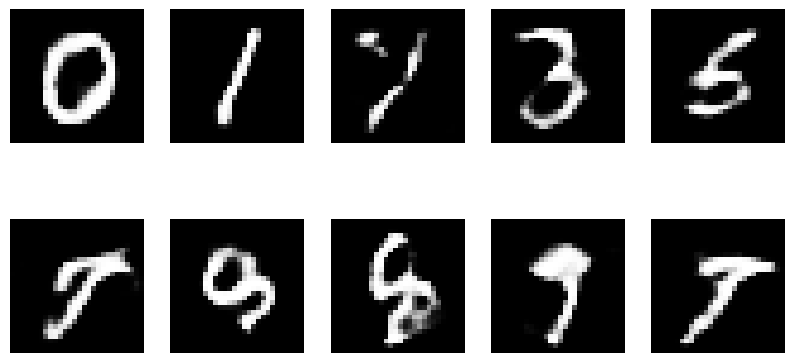

Time for epoch 27 is 19.710853576660156 sec
Epoch 28/50
Generator Loss: 0.9447
Discriminator Loss: 1.2252


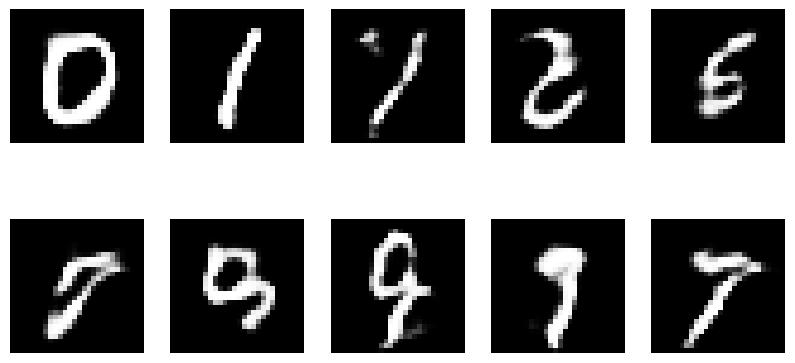

Time for epoch 28 is 19.343916654586792 sec
Epoch 29/50
Generator Loss: 0.9465
Discriminator Loss: 1.2360


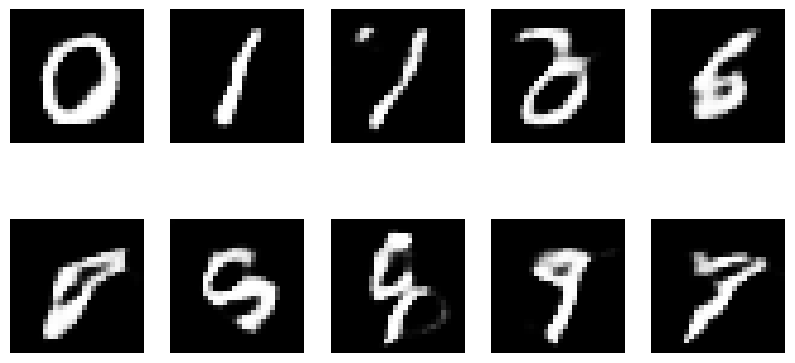

Time for epoch 29 is 19.300973653793335 sec
Epoch 30/50
Generator Loss: 0.9359
Discriminator Loss: 1.2356


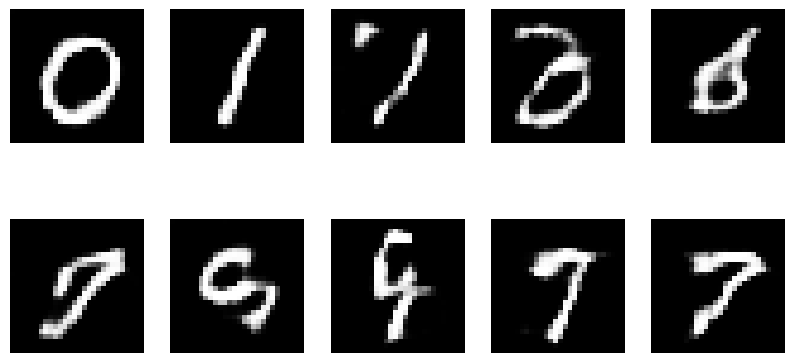

Time for epoch 30 is 19.624561309814453 sec
Epoch 31/50
Generator Loss: 0.9747
Discriminator Loss: 1.2294


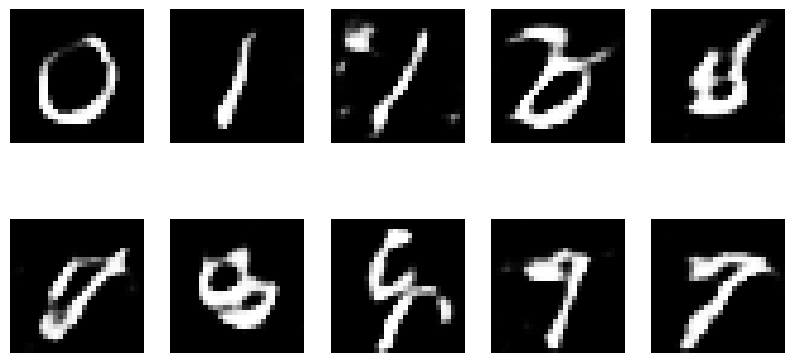

Time for epoch 31 is 19.315104961395264 sec
Epoch 32/50
Generator Loss: 0.9433
Discriminator Loss: 1.2275


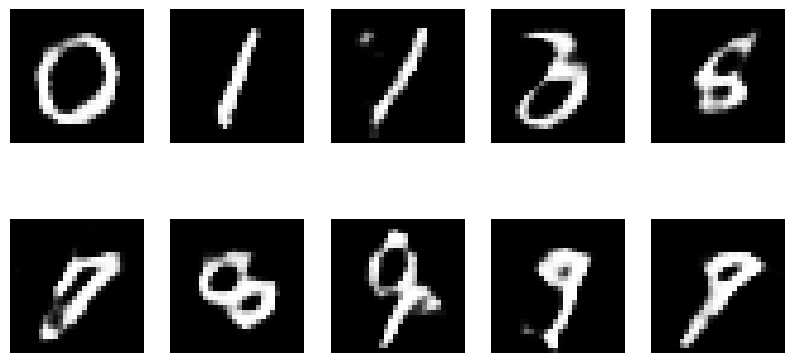

Time for epoch 32 is 19.303066730499268 sec
Epoch 33/50
Generator Loss: 0.9235
Discriminator Loss: 1.2370


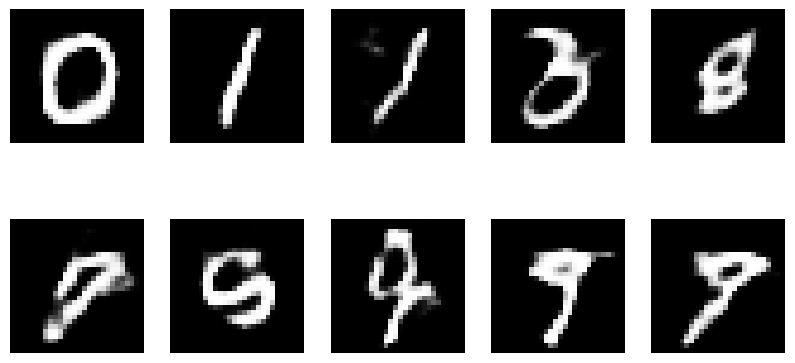

Time for epoch 33 is 19.320818662643433 sec
Epoch 34/50
Generator Loss: 0.9305
Discriminator Loss: 1.2412


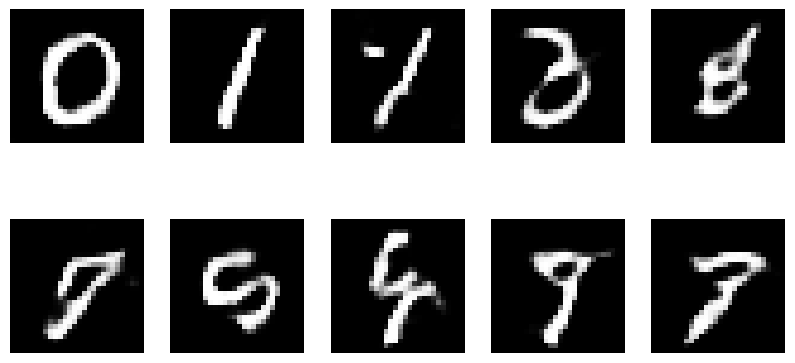

Time for epoch 34 is 19.327677011489868 sec
Epoch 35/50
Generator Loss: 0.9403
Discriminator Loss: 1.2393


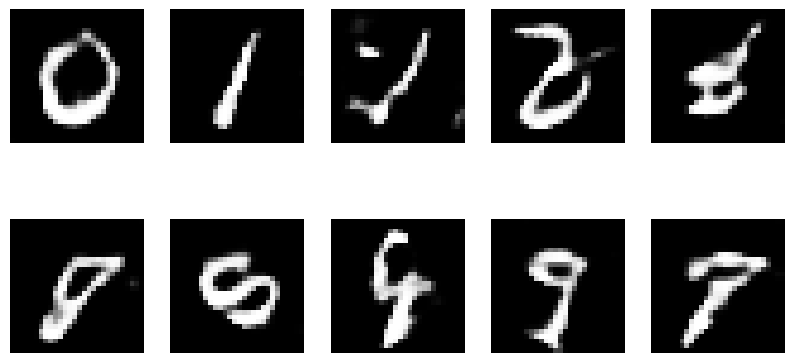

Time for epoch 35 is 19.371078729629517 sec
Epoch 36/50
Generator Loss: 0.9335
Discriminator Loss: 1.2395


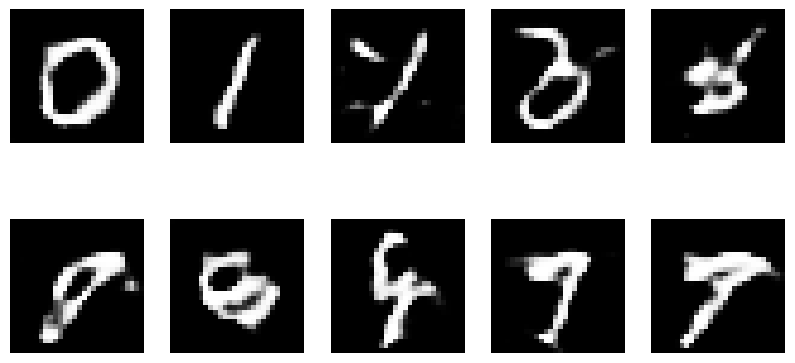

Time for epoch 36 is 19.359623193740845 sec
Epoch 37/50
Generator Loss: 0.9192
Discriminator Loss: 1.2390


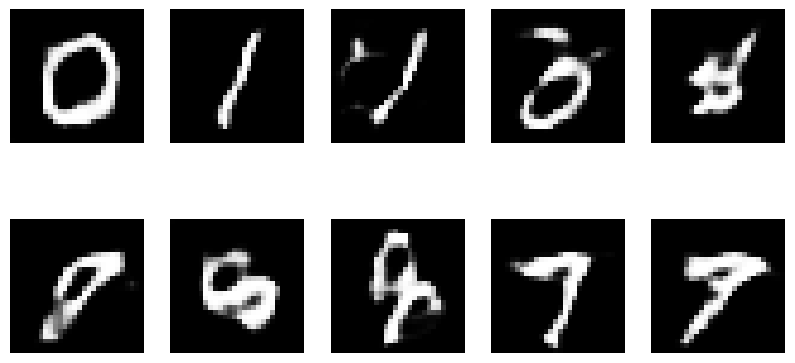

Time for epoch 37 is 19.673619985580444 sec
Epoch 38/50
Generator Loss: 0.9089
Discriminator Loss: 1.2542


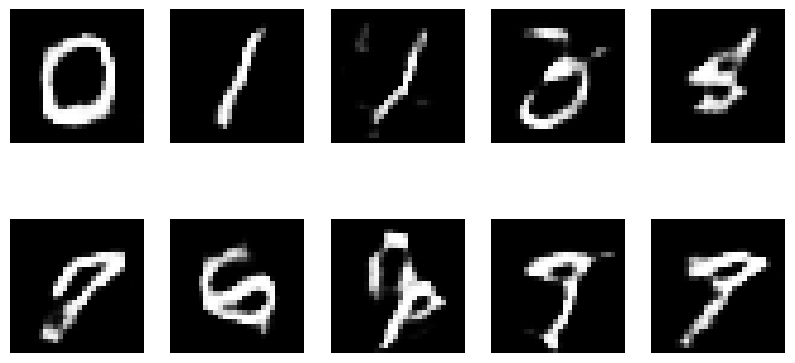

Time for epoch 38 is 19.27270817756653 sec
Epoch 39/50
Generator Loss: 0.9276
Discriminator Loss: 1.2540


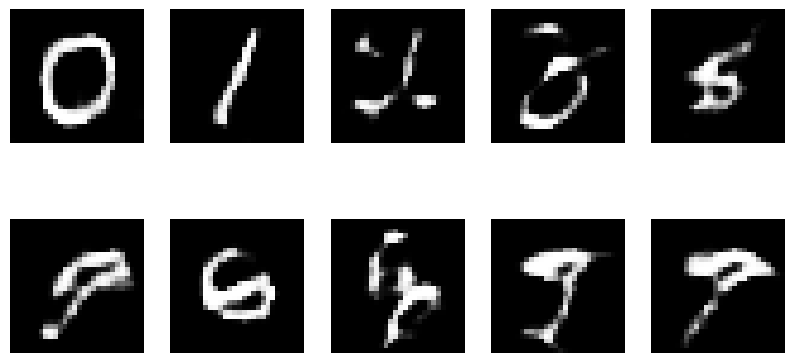

Time for epoch 39 is 19.263988733291626 sec
Epoch 40/50
Generator Loss: 0.9479
Discriminator Loss: 1.2176


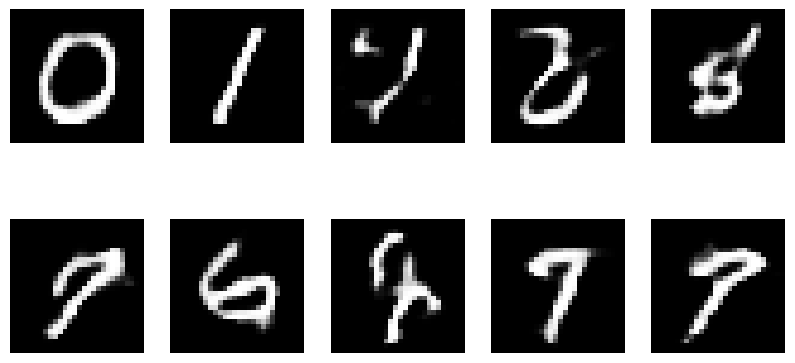

Time for epoch 40 is 19.57456374168396 sec
Epoch 41/50
Generator Loss: 0.9002
Discriminator Loss: 1.2652


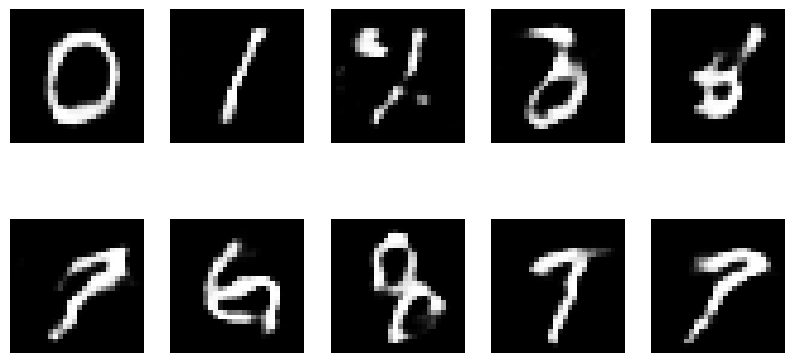

Time for epoch 41 is 19.322267770767212 sec
Epoch 42/50
Generator Loss: 0.9187
Discriminator Loss: 1.2388


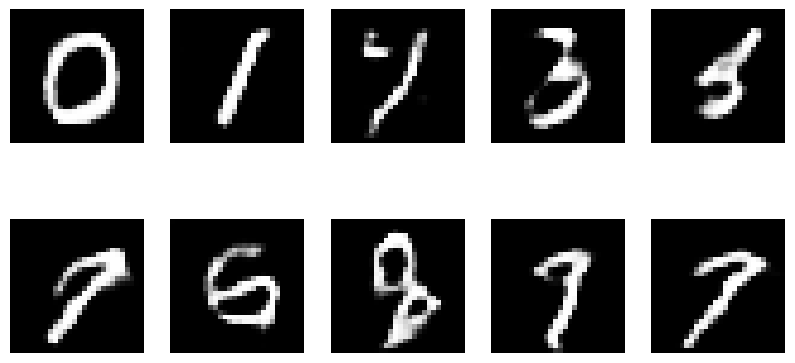

Time for epoch 42 is 19.355719566345215 sec
Epoch 43/50
Generator Loss: 0.9171
Discriminator Loss: 1.2356


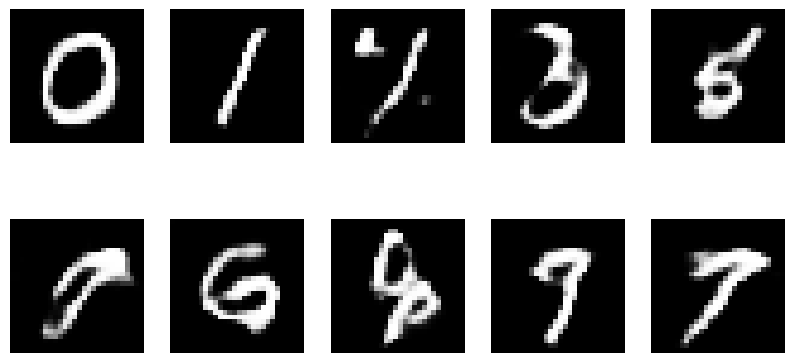

Time for epoch 43 is 19.34964919090271 sec
Epoch 44/50
Generator Loss: 0.8925
Discriminator Loss: 1.2577


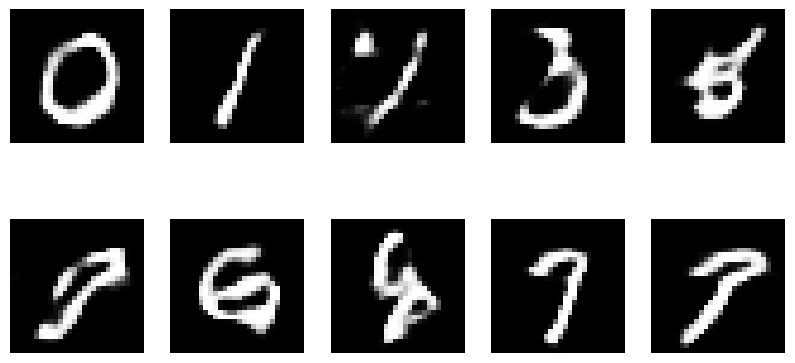

Time for epoch 44 is 19.319215059280396 sec
Epoch 45/50
Generator Loss: 0.8907
Discriminator Loss: 1.2773


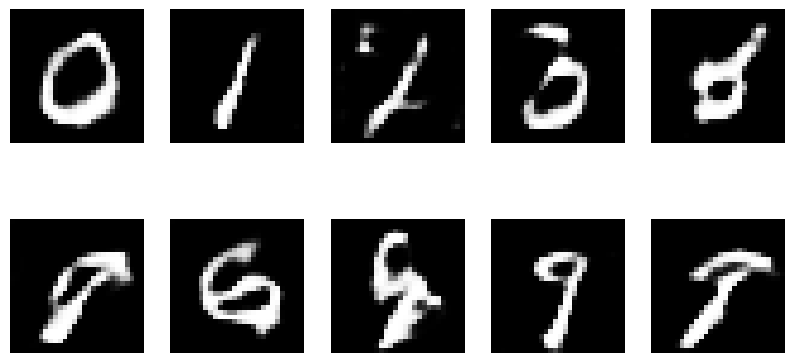

Time for epoch 45 is 19.3305025100708 sec
Epoch 46/50
Generator Loss: 0.9016
Discriminator Loss: 1.2512


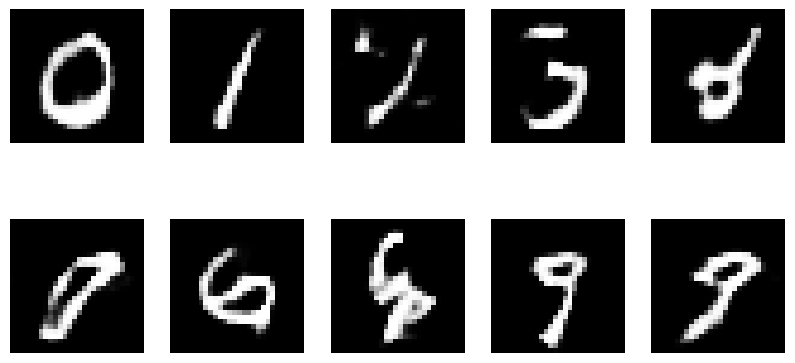

Time for epoch 46 is 19.3579523563385 sec
Epoch 47/50
Generator Loss: 0.9046
Discriminator Loss: 1.2540


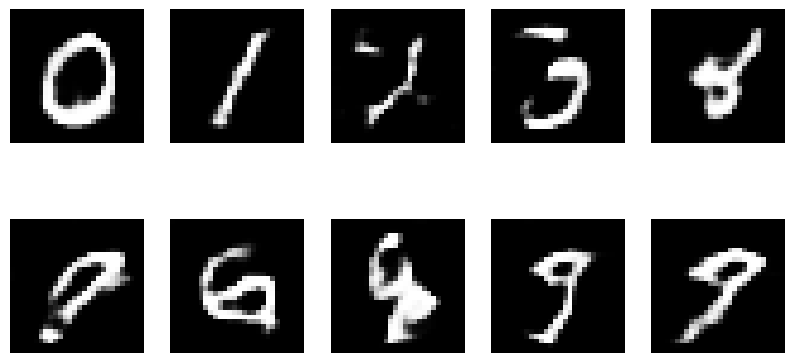

Time for epoch 47 is 19.677687406539917 sec
Epoch 48/50
Generator Loss: 0.9234
Discriminator Loss: 1.2459


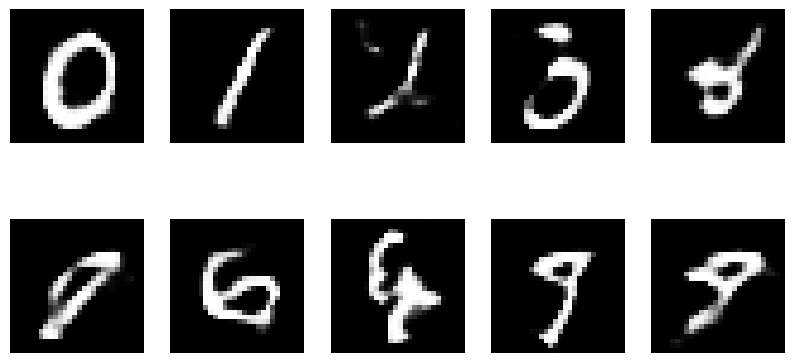

Time for epoch 48 is 19.307984828948975 sec
Epoch 49/50
Generator Loss: 0.9024
Discriminator Loss: 1.2573


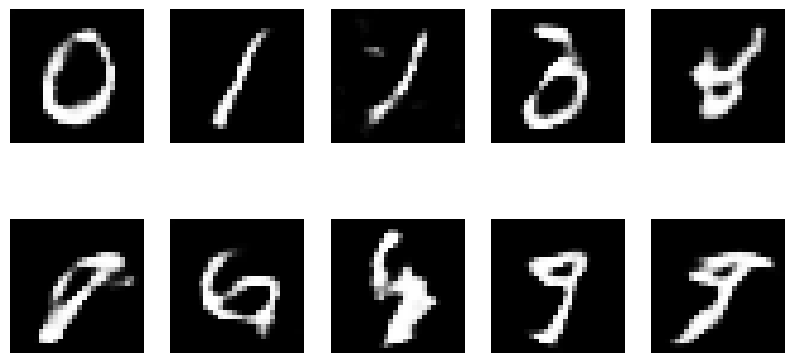

Time for epoch 49 is 19.314845323562622 sec
Epoch 50/50
Generator Loss: 0.8983
Discriminator Loss: 1.2620


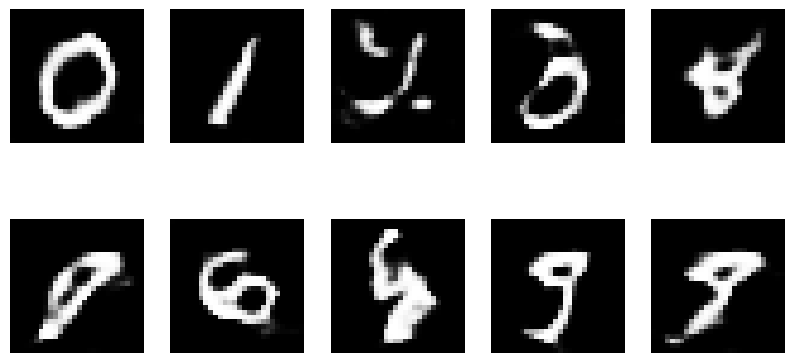

Time for epoch 50 is 19.66092562675476 sec


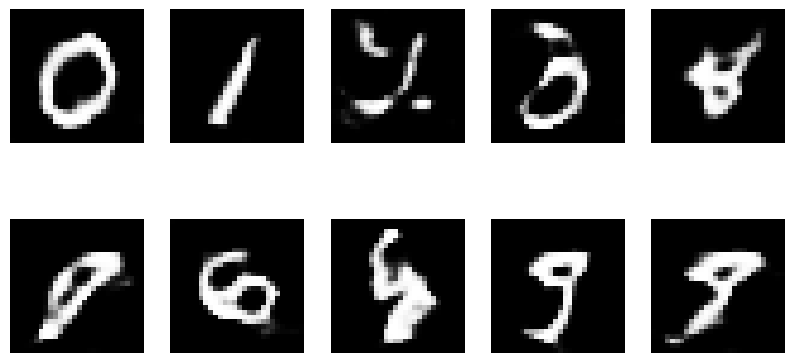

In [140]:
train(train_dataset, epochs)

In [141]:
anim_file = 'cgan_2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('epoch*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\hp\AppData\Local\Temp\ipykernel_4860\2193686690.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\hp\AppData\Local\Temp\ipykernel_4860\2193686690.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



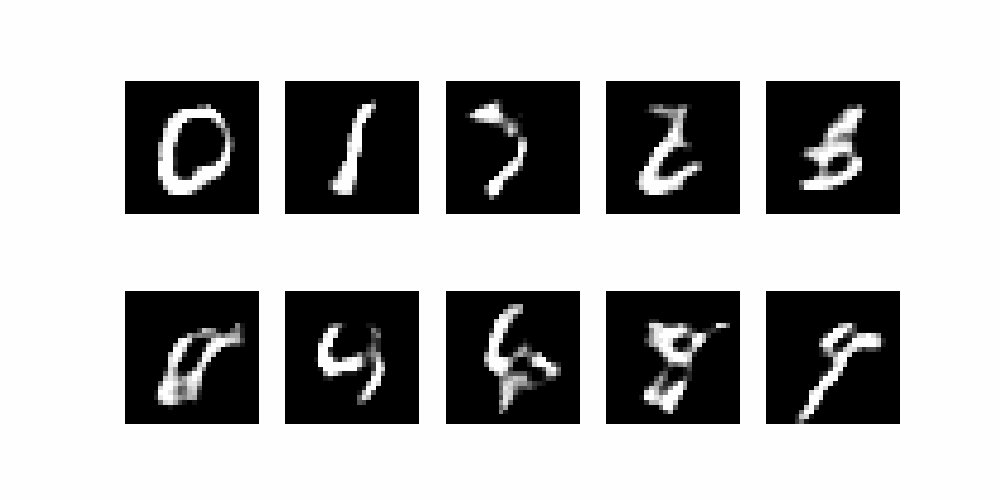

In [142]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

(10, 28, 28, 1)


TypeError: Invalid shape (10, 28, 28) for image data

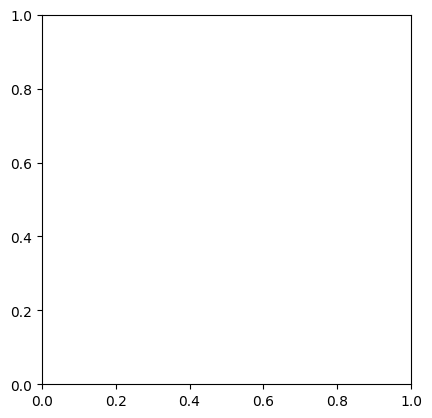

In [139]:
# G = generator()
noise = tf.random.normal([10,100])

# label = 0
# ohe = np.zeros(n_classes)
# ohe[label] = 1
ohe = np.eye(10)
G_in = np.concatenate((noise,ohe),axis=1)
# G_in = G_in[None,:]

img = G(G_in, training=False)
print(img.shape)

for i in range(pred.shape[0]):
        plt.subplot(2,5,i+1)
        plt.imshow(pred[i,:,:,0]*127.5 + 127.5, cmap='gray')
        plt.axis('off')


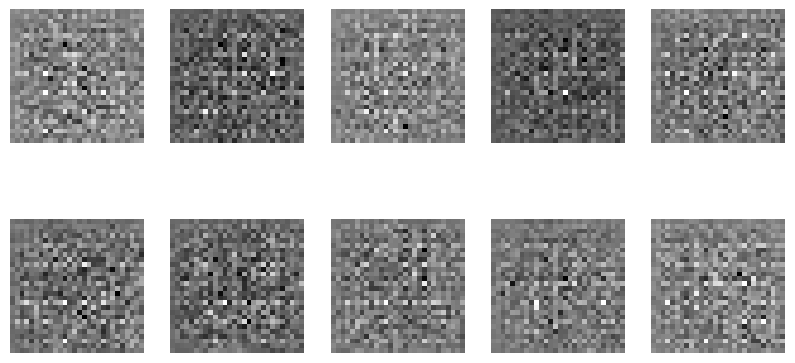

In [84]:
generate_and_save_images(G,epochs,seed)